In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score


In [2]:
# Load data before feature engineering
train_df = pd.read_csv("data/processed/train_processed.csv")
val_df = pd.read_csv("data/processed/validation_processed.csv")

# Separate features & target
X_train, y_train = train_df.drop(columns=["Attrition"]), train_df["Attrition"]
X_val, y_val = val_df.drop(columns=["Attrition"]), val_df["Attrition"]

print(X_train.isnull().sum())

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

print("XGBoost Results:")
print("Accuracy:", accuracy_score(y_val, xgb_preds))
print(classification_report(y_val, xgb_preds, target_names=["Stayed", "Left"]))

Age                                  0
Gender                               0
Years at Company                     0
Monthly Income                       0
Number of Promotions                 0
Overtime                             0
Distance from Home                   0
Number of Dependents                 0
Remote Work                          0
Leadership Opportunities             0
Innovation Opportunities             0
Job Role_Education                   0
Job Role_Finance                     0
Job Role_Healthcare                  0
Job Role_Media                       0
Job Role_Technology                  0
Work-Life Balance_Excellent          0
Work-Life Balance_Fair               0
Work-Life Balance_Good               0
Work-Life Balance_Poor               0
Job Satisfaction_High                0
Job Satisfaction_Low                 0
Job Satisfaction_Medium              0
Job Satisfaction_Very High           0
Performance Rating_Average           0
Performance Rating_Below 

/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:15:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results:
Accuracy: 0.7578983224048369
              precision    recall  f1-score   support

      Stayed       0.77      0.77      0.77      6124
        Left       0.75      0.75      0.75      5619

    accuracy                           0.76     11743
   macro avg       0.76      0.76      0.76     11743
weighted avg       0.76      0.76      0.76     11743



Top 10 Most Important Features:
                   feature  importance
38        Job Level_Senior    0.171835
35   Marital Status_Single    0.136495
8              Remote Work    0.074829
36         Job Level_Entry    0.073909
37           Job Level_Mid    0.038329
17  Work-Life Balance_Fair    0.036537
32     Education Level_PhD    0.032827
19  Work-Life Balance_Poor    0.030628
1                   Gender    0.029130
4     Number of Promotions    0.026638


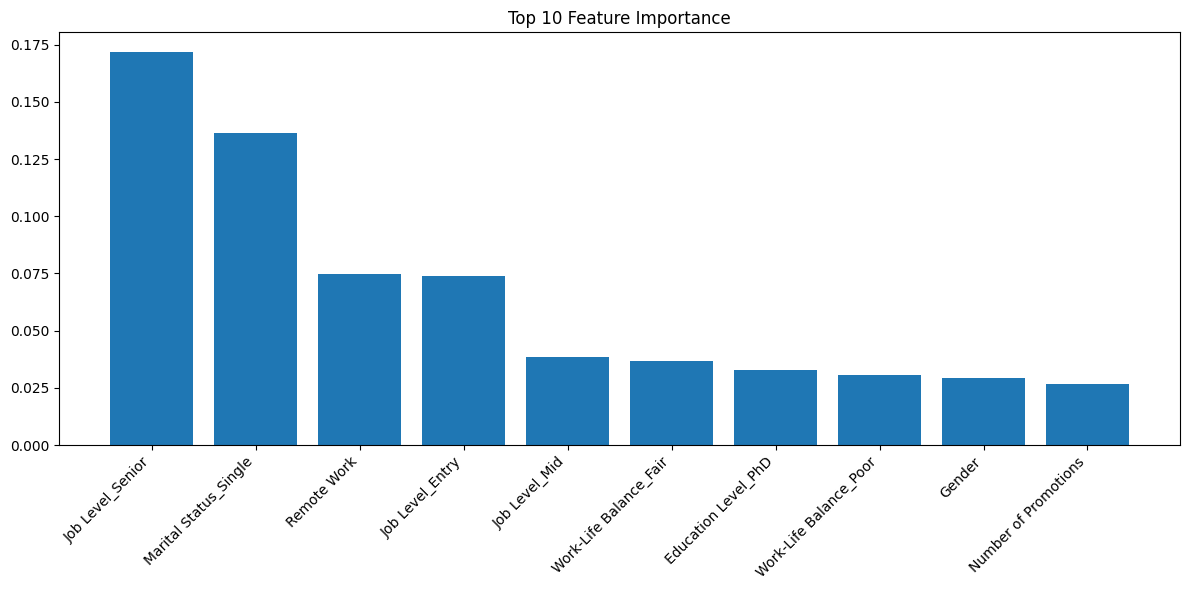

In [3]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Visualize
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

In [16]:
# Load data after feature engineering
train_df = pd.read_csv("data/processed/train_engineered.csv")
val_df = pd.read_csv("data/processed/validation_engineered.csv")

# Separate features & target
X_train, y_train = train_df.drop(columns=["Attrition"]), train_df["Attrition"]
X_val, y_val = val_df.drop(columns=["Attrition"]), val_df["Attrition"]

print(X_train.isnull().sum())

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

print("XGBoost Results:")
print("Accuracy:", accuracy_score(y_val, xgb_preds))
print(classification_report(y_val, xgb_preds, target_names=["Stayed", "Left"]))

Age                     0
Gender                  0
Years at Company        0
Monthly Income          0
Number of Promotions    0
                       ..
Tenure_Stage_Mid        0
Tenure_Stage_Senior     0
Distance_Bin_Far        0
Distance_Bin_Medium     0
Distance_Bin_Near       0
Length: 68, dtype: int64


/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:21:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results:
Accuracy: 0.7870872804193875
              precision    recall  f1-score   support

      Stayed       0.80      0.79      0.80      5681
        Left       0.78      0.78      0.78      5192

    accuracy                           0.79     10873
   macro avg       0.79      0.79      0.79     10873
weighted avg       0.79      0.79      0.79     10873



Top 10 Most Important Features:
                    feature  importance
50         Job Level_Senior    0.165790
47    Marital Status_Single    0.131793
8               Remote Work    0.074397
48          Job Level_Entry    0.062609
21  Work_Life_Balance_Level    0.050594
49            Job Level_Mid    0.037454
44      Education Level_PhD    0.033547
4      Number of Promotions    0.029924
1                    Gender    0.028621
7      Number of Dependents    0.028441


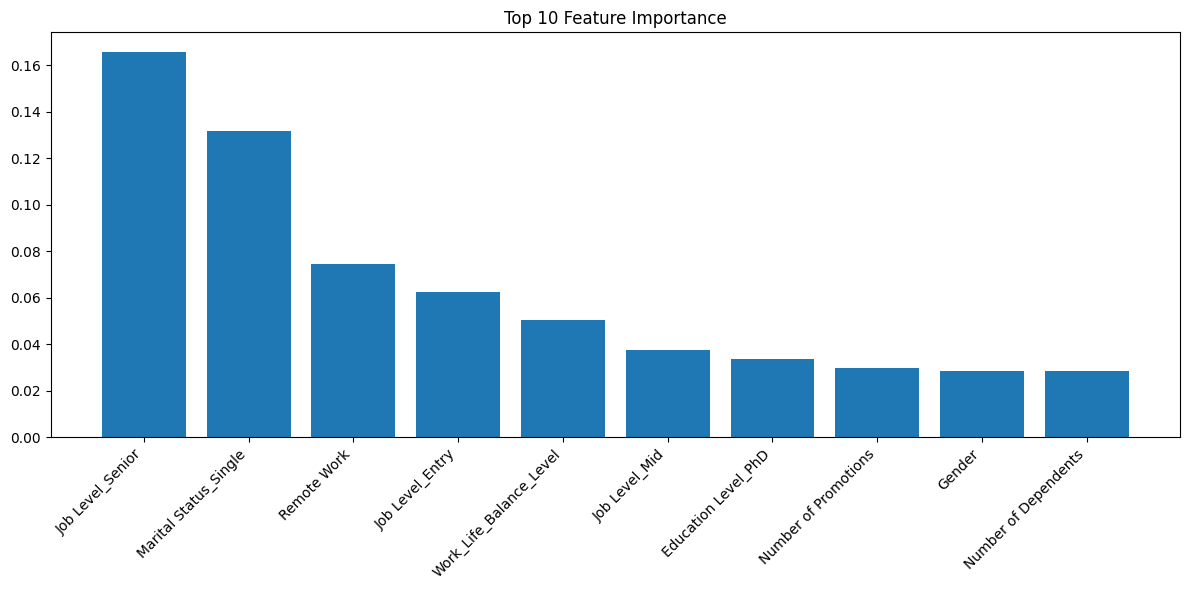

In [17]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Visualize
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

In [18]:
def train_segmented_xgboost(X_train, y_train, X_val, y_val):
    """
    Train separate XGBoost models for different job level segments
    
    Parameters:
    X_train, y_train: Training data
    X_val, y_val: Validation data
    
    Returns:
    Dictionary containing models and results for each segment
    """
    # Define segments
    segments = {
        'senior': (X_train['Job Level_Senior'] == 1, X_val['Job Level_Senior'] == 1),
        'entry': (X_train['Job Level_Entry'] == 1, X_val['Job Level_Entry'] == 1),
        'mid': (X_train['Job Level_Mid'] == 1, X_val['Job Level_Mid'] == 1)
    }
    
    segment_models = {}
    segment_results = {}
    
    for segment_name, (train_mask, val_mask) in segments.items():
        print(f"\n=== Processing {segment_name} segment ===")
        
        # Get segment data
        X_train_segment = X_train[train_mask]
        y_train_segment = y_train[train_mask]
        X_val_segment = X_val[val_mask]
        y_val_segment = y_val[val_mask]
        
        print(f"Segment size - Train: {len(X_train_segment)}, Val: {len(X_val_segment)}")
        
        # Train XGBoost model for segment
        model = xgb.XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=4,
            random_state=42
        )
        
        # Fit model
        model.fit(X_train_segment, y_train_segment)
        
        # Make predictions
        y_pred = model.predict(X_val_segment)
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_val_segment, y_pred),
            'precision': precision_score(y_val_segment, y_pred),
            'recall': recall_score(y_val_segment, y_pred),
            'f1': f1_score(y_val_segment, y_pred)
        }
        
        # Get feature importance
        feature_imp = pd.DataFrame({
            'feature': X_train_segment.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Store results
        segment_models[segment_name] = model
        segment_results[segment_name] = {
            'metrics': metrics,
            'feature_importance': feature_imp,
            'predictions': y_pred,
            'actual': y_val_segment
        }
        
        # Print results
        print(f"\nResults for {segment_name} segment:")
        print("\nClassification Report:")
        print(classification_report(y_val_segment, y_pred))
        
        print("\nTop 5 Important Features:")
        print(feature_imp.head())
    
    # Visualize results
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Accuracy by segment
    plt.subplot(1, 3, 1)
    accuracies = [results['metrics']['accuracy'] 
                  for results in segment_results.values()]
    plt.bar(segment_results.keys(), accuracies)
    plt.title('Accuracy by Segment')
    plt.ylabel('Accuracy')
    plt.ylim(0.5, 1.0)
    
    # Plot 2: Feature Importance Comparison
    plt.subplot(1, 3, 2)
    for segment_name, results in segment_results.items():
        top_feature = results['feature_importance'].iloc[0]
        plt.bar(segment_name, top_feature['importance'], 
                label=top_feature['feature'])
    plt.title('Top Feature Importance by Segment')
    plt.legend(title='Top Feature')
    
    # Plot 3: Metrics Comparison
    plt.subplot(1, 3, 3)
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    x = np.arange(len(metrics))
    width = 0.25
    
    for i, (segment_name, results) in enumerate(segment_results.items()):
        values = [results['metrics'][m] for m in metrics]
        plt.bar(x + i*width, values, width, label=segment_name)
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Metrics by Segment')
    plt.xticks(x + width, metrics)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'models': segment_models,
        'results': segment_results
    }

# Run the segmented analysis
segmented_results = train_segmented_xgboost(X_train, y_train, X_val, y_val)

# Print overall summary
print("\n=== Overall Summary ===")
for segment_name, results in segmented_results['results'].items():
    print(f"\n{segment_name} segment:")
    for metric, value in results['metrics'].items():
        print(f"{metric}: {value:.3f}")


=== Processing senior segment ===
Segment size - Train: 10940, Val: 2252


NameError: name 'precision_score' is not defined


=== Error Analysis for senior ===

Characteristics of misclassified cases:

Remote Work:
Misclassified distribution:
Remote Work
0    0.960227
1    0.039773
Name: proportion, dtype: float64

Correct distribution:
Remote Work
0    0.779474
1    0.220526
Name: proportion, dtype: float64

Marital Status_Single:
Misclassified distribution:
Marital Status_Single
1.0    0.545455
0.0    0.454545
Name: proportion, dtype: float64

Correct distribution:
Marital Status_Single
0.0    0.68
1.0    0.32
Name: proportion, dtype: float64

Work-Life Balance_Poor:
Misclassified distribution:
Work-Life Balance_Poor
0.0    0.815341
1.0    0.184659
Name: proportion, dtype: float64

Correct distribution:
Work-Life Balance_Poor
0.0    0.871579
1.0    0.128421
Name: proportion, dtype: float64

Prediction Confidence Analysis:
Average confidence when correct: 0.855
Average confidence when wrong: 0.665

=== Error Analysis for entry ===

Characteristics of misclassified cases:

Remote Work:
Misclassified distribu

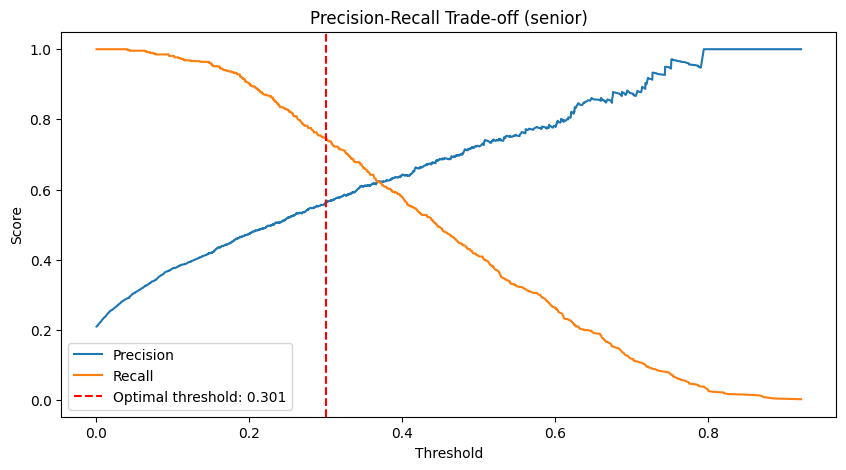


entry optimal threshold: 0.447

Results with optimal threshold:
              precision    recall  f1-score   support

           0       0.77      0.51      0.61      1579
           1       0.76      0.91      0.83      2742

    accuracy                           0.77      4321
   macro avg       0.77      0.71      0.72      4321
weighted avg       0.77      0.77      0.75      4321



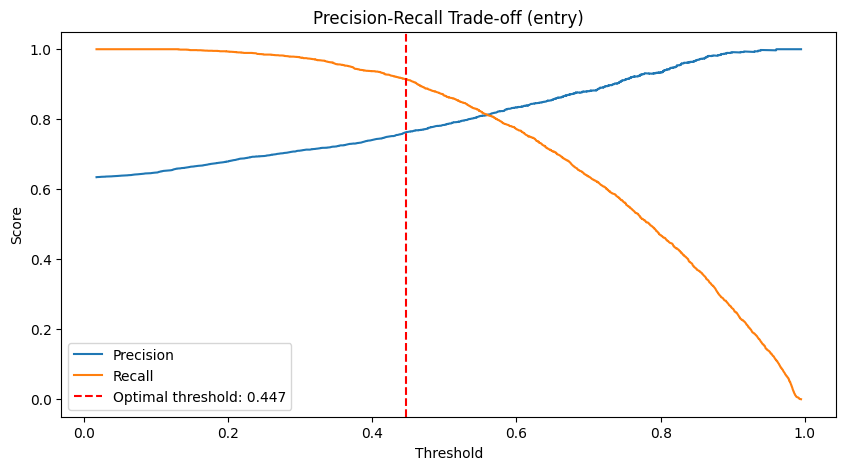


mid optimal threshold: 0.419

Results with optimal threshold:
              precision    recall  f1-score   support

           0       0.82      0.70      0.76      2322
           1       0.70      0.82      0.75      1978

    accuracy                           0.76      4300
   macro avg       0.76      0.76      0.76      4300
weighted avg       0.76      0.76      0.76      4300



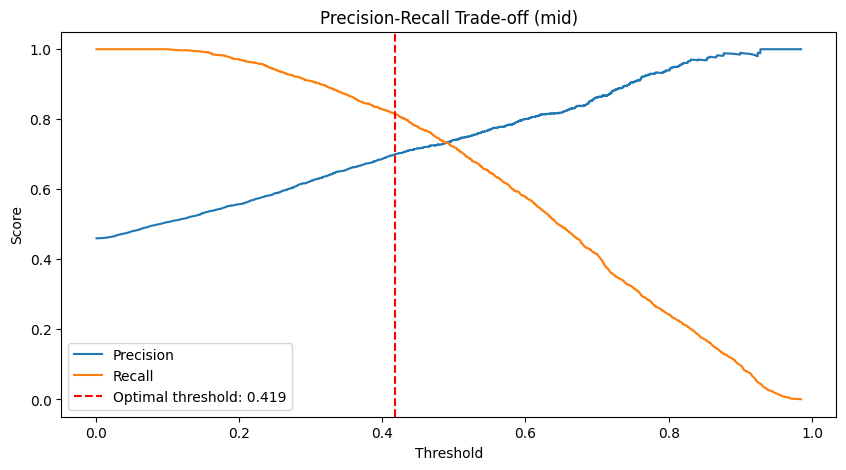

In [ ]:
def perform_deep_analysis(X_train, y_train, X_val, y_val, segment_models, segment_results):
    """
    Detailed analysis of model performance and patterns
    
    Parameters:
    X_train, y_train: Training data
    X_val, y_val: Validation data
    segment_models: Dictionary of trained models for each segment
    segment_results: Dictionary of results for each segment
    """
    
    # 1. Error Analysis
    for segment_name, model in segment_models.items():
        print(f"\n=== Error Analysis for {segment_name} ===")
        
        # Get segment data
        segment_mask = X_val['Job Level_' + segment_name.split('_')[0].capitalize()] == 1
        X_val_segment = X_val[segment_mask]
        y_val_segment = y_val[segment_mask]
        
        # Get predictions
        y_pred = model.predict(X_val_segment)
        y_pred_proba = model.predict_proba(X_val_segment)
        
        # Analyze misclassified cases
        misclassified = X_val_segment[y_pred != y_val_segment]
        correct = X_val_segment[y_pred == y_val_segment]
        
        print("\nCharacteristics of misclassified cases:")
        for col in ['Remote Work', 'Marital Status_Single', 'Work-Life Balance_Poor']:
            if col in misclassified.columns:
                print(f"\n{col}:")
                print("Misclassified distribution:")
                print(misclassified[col].value_counts(normalize=True))
                print("\nCorrect distribution:")
                print(correct[col].value_counts(normalize=True))
        
        # Analyze prediction confidence
        print("\nPrediction Confidence Analysis:")
        confident_correct = np.max(y_pred_proba[y_pred == y_val_segment], axis=1)
        confident_wrong = np.max(y_pred_proba[y_pred != y_val_segment], axis=1)
        print(f"Average confidence when correct: {confident_correct.mean():.3f}")
        print(f"Average confidence when wrong: {confident_wrong.mean():.3f}")
    
    # 2. Feature Interaction Analysis
    print("\n=== Feature Interaction Analysis ===")
    for segment_name, model in segment_models.items():
        print(f"\n{segment_name} key interactions:")
        
        # Get top features
        top_features = segment_results[segment_name]['feature_importance']['feature'].head(3).tolist()
        
        # Analyze interactions between top features
        for i in range(len(top_features)):
            for j in range(i+1, len(top_features)):
                if top_features[i] in X_train.columns and top_features[j] in X_train.columns:
                    interaction_df = pd.DataFrame({
                        'feature1': X_train[top_features[i]],
                        'feature2': X_train[top_features[j]],
                        'target': y_train
                    })
                    print(f"\nInteraction between {top_features[i]} and {top_features[j]}:")
                    print(interaction_df.groupby(['feature1', 'feature2'])['target'].mean())
    
    # 3. Threshold Analysis
    print("\n=== Threshold Optimization ===")
    from sklearn.metrics import precision_recall_curve
    
    for segment_name, model in segment_models.items():
        segment_mask = X_val['Job Level_' + segment_name.split('_')[0].capitalize()] == 1
        X_val_segment = X_val[segment_mask]
        y_val_segment = y_val[segment_mask]
        
        y_pred_proba = model.predict_proba(X_val_segment)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y_val_segment, y_pred_proba)
        
        # Find optimal threshold
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
        optimal_threshold = thresholds[np.argmax(f1_scores[:-1])]
        
        print(f"\n{segment_name} optimal threshold: {optimal_threshold:.3f}")
        
        # Compare results with optimal threshold
        y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
        print("\nResults with optimal threshold:")
        print(classification_report(y_val_segment, y_pred_optimal))

        # Visualize threshold impact
        plt.figure(figsize=(10, 5))
        plt.plot(thresholds, precisions[:-1], label='Precision')
        plt.plot(thresholds, recalls[:-1], label='Recall')
        plt.axvline(x=optimal_threshold, color='r', linestyle='--', 
                   label=f'Optimal threshold: {optimal_threshold:.3f}')
        plt.title(f'Precision-Recall Trade-off ({segment_name})')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.legend()
        plt.show()

    return {
        'optimal_thresholds': optimal_threshold,
        'misclassification_analysis': {
            'correct_confidence': confident_correct,
            'wrong_confidence': confident_wrong
        }
    }

# Run deep analysis
analysis_results = perform_deep_analysis(X_train, y_train, X_val, y_val, 
                                       segmented_results['models'], 
                                       segmented_results['results'])

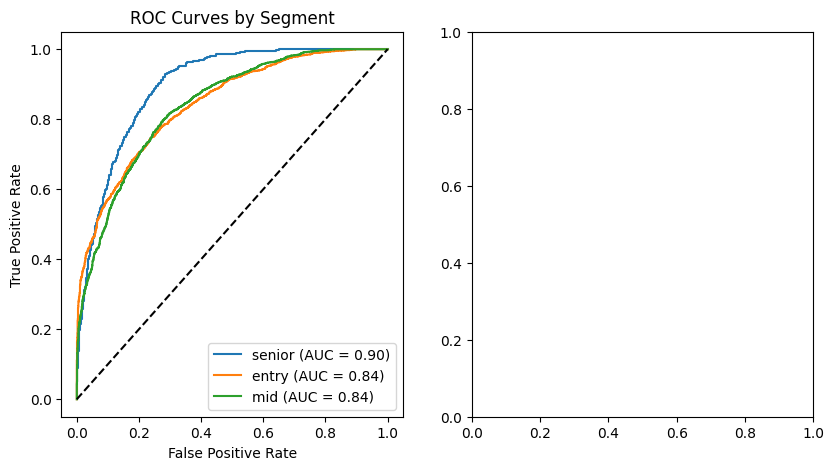

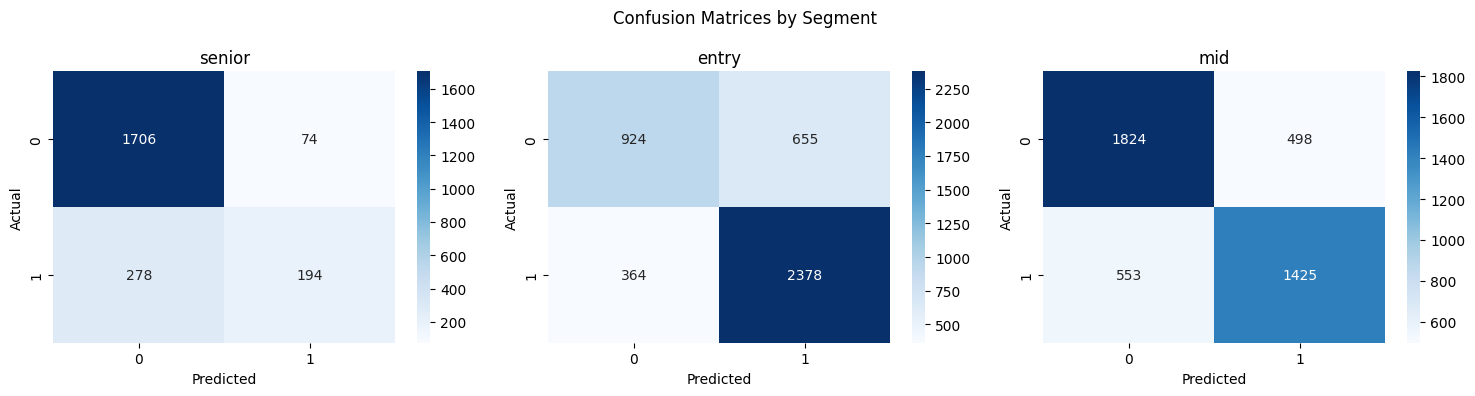

<Figure size 1200x600 with 0 Axes>

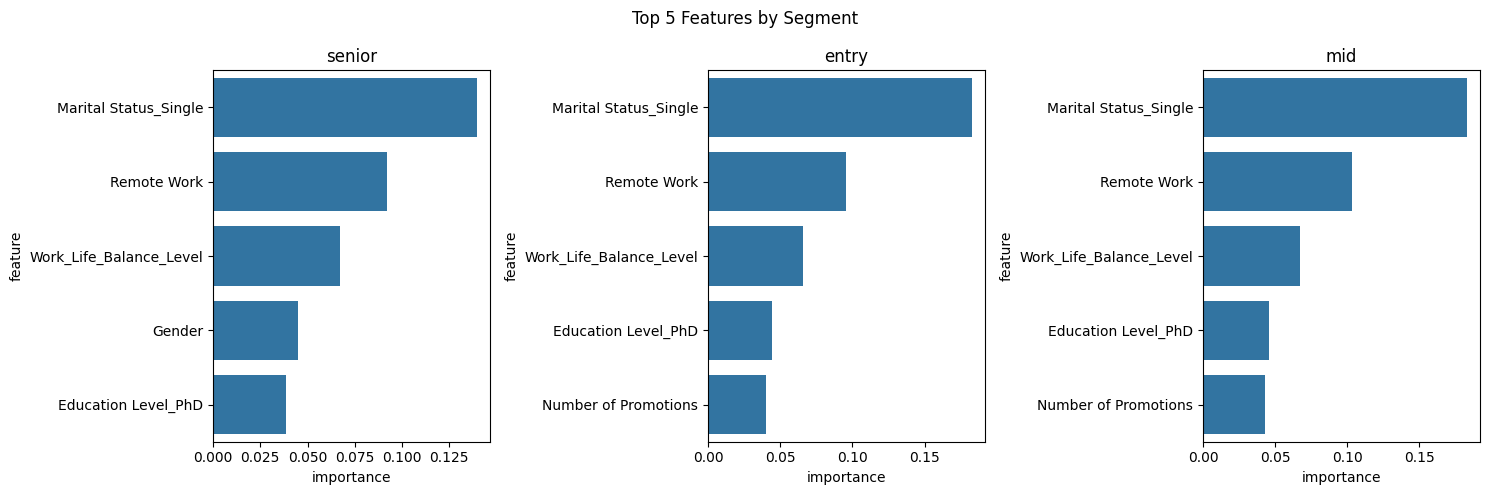

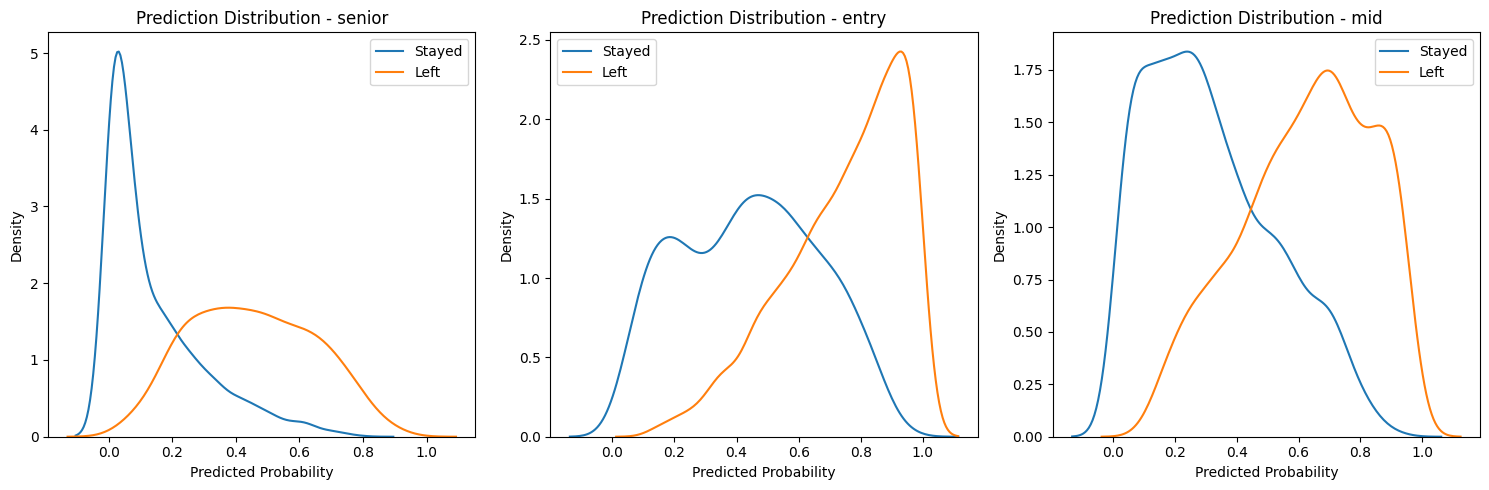

<Figure size 1000x600 with 0 Axes>

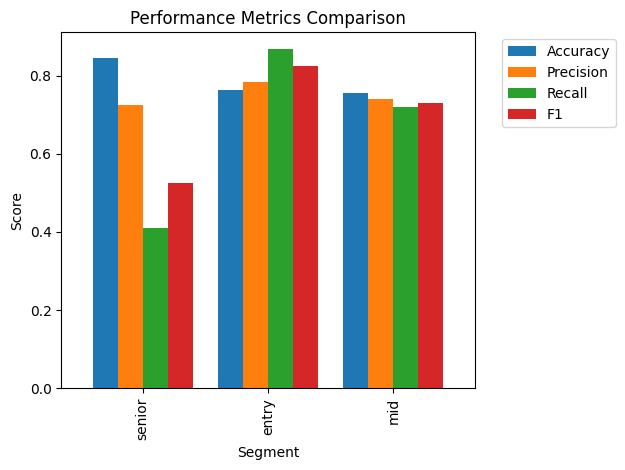

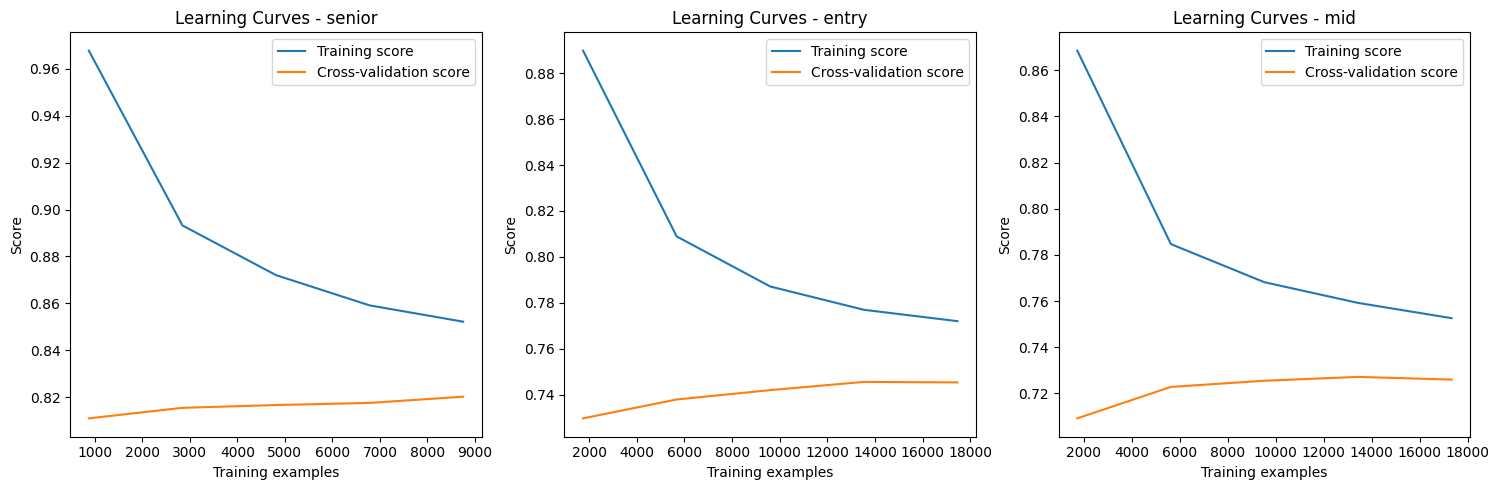

In [ ]:
def create_model_visualizations(X_train, y_train, X_val, y_val, segment_models, segment_results):
    """
    Create comprehensive visualizations for model analysis
    """
    
    # 1. ROC Curves
    plt.figure(figsize=(15, 5))
    
    # Plot ROC for each segment
    plt.subplot(1, 3, 1)
    for segment_name, model in segment_models.items():
        segment_mask = X_val['Job Level_' + segment_name.split('_')[0].capitalize()] == 1
        X_val_segment = X_val[segment_mask]
        y_val_segment = y_val[segment_mask]
        
        y_pred_proba = model.predict_proba(X_val_segment)[:, 1]
        fpr, tpr, _ = roc_curve(y_val_segment, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{segment_name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves by Segment')
    plt.legend()
    
    # 2. Confusion Matrices
    plt.subplot(1, 3, 2)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle('Confusion Matrices by Segment')
    
    for i, (segment_name, model) in enumerate(segment_models.items()):
        segment_mask = X_val['Job Level_' + segment_name.split('_')[0].capitalize()] == 1
        X_val_segment = X_val[segment_mask]
        y_val_segment = y_val[segment_mask]
        
        y_pred = model.predict(X_val_segment)
        cm = confusion_matrix(y_val_segment, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
        axes[i].set_title(f'{segment_name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.tight_layout()
    
    # 3. Feature Importance Comparison
    plt.figure(figsize=(12, 6))
    
    # Get top 5 features for each segment
    top_features = {}
    for segment_name, results in segment_results.items():
        top_features[segment_name] = results['feature_importance'].head(5)
    
    # Plot feature importance
    n_segments = len(segment_models)
    fig, axes = plt.subplots(1, n_segments, figsize=(15, 5))
    fig.suptitle('Top 5 Features by Segment')
    
    for i, (segment_name, features) in enumerate(top_features.items()):
        sns.barplot(x='importance', y='feature', data=features, ax=axes[i])
        axes[i].set_title(segment_name)
    
    plt.tight_layout()
    
    # 4. Prediction Distribution
    plt.figure(figsize=(15, 5))
    
    for i, (segment_name, model) in enumerate(segment_models.items()):
        plt.subplot(1, 3, i+1)
        segment_mask = X_val['Job Level_' + segment_name.split('_')[0].capitalize()] == 1
        X_val_segment = X_val[segment_mask]
        y_val_segment = y_val[segment_mask]
        
        y_pred_proba = model.predict_proba(X_val_segment)[:, 1]
        
        # Plot distribution for each class
        for label in [0, 1]:
            sns.kdeplot(y_pred_proba[y_val_segment == label], 
                       label=f'Class {label}')
        
        plt.title(f'Prediction Distribution - {segment_name}')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Density')
        plt.legend(['Stayed', 'Left'])
    
    plt.tight_layout()
    
    # 5. Performance Metrics Comparison
    metrics_df = pd.DataFrame([
        {
            'Segment': segment_name,
            'Accuracy': results['metrics']['accuracy'],
            'Precision': results['metrics']['precision'],
            'Recall': results['metrics']['recall'],
            'F1': results['metrics']['f1']
        }
        for segment_name, results in segment_results.items()
    ])
    
    plt.figure(figsize=(10, 6))
    metrics_df.set_index('Segment').plot(kind='bar', width=0.8)
    plt.title('Performance Metrics Comparison')
    plt.ylabel('Score')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    
    # 6. Learning Curves
    
    plt.figure(figsize=(15, 5))
    for i, (segment_name, model) in enumerate(segment_models.items()):
        plt.subplot(1, 3, i+1)
        segment_mask = X_train['Job Level_' + segment_name.split('_')[0].capitalize()] == 1
        X_train_segment = X_train[segment_mask]
        y_train_segment = y_train[segment_mask]
        
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train_segment, y_train_segment,
            cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))
        
        plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
        plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
        plt.title(f'Learning Curves - {segment_name}')
        plt.xlabel('Training examples')
        plt.ylabel('Score')
        plt.legend(loc='best')
    
    plt.tight_layout()
    
    return {
        'metrics_comparison': metrics_df,
        'top_features': top_features
    }

# Run visualizations
visualization_results = create_model_visualizations(
    X_train, y_train, X_val, y_val,
    segmented_results['models'],
    segmented_results['results']
)

In [ ]:
def analyze_and_train_subsegments(X_train, y_train, X_val, y_val):
    """Create and analyze sub-segments for entry and mid-level employees"""
    
    def create_subsegments(X, y, level_col):
        """Create meaningful subsegments based on key characteristics"""
        subsegments = {}
        
        # Remote vs Non-Remote split
        remote_mask = X['Remote Work'] == 1
        non_remote_mask = X['Remote Work'] == 0
        
        # Experience level (for entry)
        if 'Years at Company' in X.columns:
            new_hire_mask = X['Years at Company'] <= 1
            established_mask = X['Years at Company'] > 1
        
        # Performance split (if available)
        high_performer_mask = X['Performance Rating_High'] == 1
        low_performer_mask = X['Performance Rating_Below Average'] == 1
        
        # Work-Life Balance split
        good_wlb_mask = (X['Work-Life Balance_Good'] == 1) | (X['Work-Life Balance_Excellent'] == 1)
        poor_wlb_mask = (X['Work-Life Balance_Poor'] == 1) | (X['Work-Life Balance_Fair'] == 1)
        
        if level_col == 'Job Level_Entry':
            subsegments = {
                'new_remote': remote_mask & new_hire_mask,
                'new_non_remote': non_remote_mask & new_hire_mask,
                'established_remote': remote_mask & established_mask,
                'established_non_remote': non_remote_mask & established_mask,
                'high_performer': high_performer_mask,
                'low_performer': low_performer_mask
            }
        else:  # Mid-level
            subsegments = {
                'remote_good_wlb': remote_mask & good_wlb_mask,
                'remote_poor_wlb': remote_mask & poor_wlb_mask,
                'non_remote_good_wlb': non_remote_mask & good_wlb_mask,
                'non_remote_poor_wlb': non_remote_mask & poor_wlb_mask,
                'high_performer': high_performer_mask,
                'low_performer': low_performer_mask
            }
            
        return subsegments
    
    results = {}
    
    # Process each main segment
    for level in ['Entry', 'Mid']:
        print(f"\n=== Analysis for {level} Level Subsegments ===")
        
        # Get main segment data
        level_col = f'Job Level_{level}'
        train_mask = X_train[level_col] == 1
        val_mask = X_val[level_col] == 1
        
        X_train_segment = X_train[train_mask]
        y_train_segment = y_train[train_mask]
        X_val_segment = X_val[val_mask]
        y_val_segment = y_val[val_mask]
        
        # Create subsegments
        subsegments = create_subsegments(X_train_segment, y_train_segment, level_col)
        
        # Train and evaluate models for each subsegment
        subsegment_results = {}
        
        for subseg_name, subseg_mask in subsegments.items():
            if subseg_mask.sum() < 100:  # Skip if subsegment is too small
                print(f"Skipping {subseg_name} - insufficient data ({subseg_mask.sum()} samples)")
                continue
                
            print(f"\nProcessing {level} - {subseg_name}")
            print(f"Subsegment size: {subseg_mask.sum()} ({subseg_mask.sum()/len(X_train_segment):.1%} of segment)")
            
            # Get subsegment data
            X_train_subseg = X_train_segment[subseg_mask]
            y_train_subseg = y_train_segment[subseg_mask]
            
            # Create corresponding validation mask
            val_subseg_mask = create_subsegments(X_val_segment, y_val_segment, level_col)[subseg_name]
            X_val_subseg = X_val_segment[val_subseg_mask]
            y_val_subseg = y_val_segment[val_subseg_mask]
            
            # Train model with specific parameters for subsegment
            model = xgb.XGBClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=4,  # Reduced to prevent overfitting
                min_child_weight=2,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42
            )
            
            # Train and evaluate
            model.fit(X_train_subseg, y_train_subseg)
            y_pred = model.predict(X_val_subseg)
            
            # Calculate metrics
            accuracy = accuracy_score(y_val_subseg, y_pred)
            report = classification_report(y_val_subseg, y_pred, output_dict=True)
            
            # Get feature importance
            feature_imp = pd.DataFrame({
                'feature': X_train_subseg.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(f"\nAccuracy for {subseg_name}: {accuracy:.4f}")
            print("\nTop 5 important features:")
            print(feature_imp.head())
            print("\nClassification Report:")
            print(classification_report(y_val_subseg, y_pred))
            
            # Store results
            subsegment_results[subseg_name] = {
                'model': model,
                'accuracy': accuracy,
                'report': report,
                'feature_importance': feature_imp,
                'size': subseg_mask.sum()
            }
        
        results[level] = subsegment_results
        
        # Analyze patterns across subsegments
        print(f"\n=== Summary for {level} Level ===")
        accuracies = {name: res['accuracy'] for name, res in subsegment_results.items()}
        print("\nAccuracies across subsegments:")
        for name, acc in accuracies.items():
            print(f"{name}: {acc:.4f}")
        
        # Find best performing subsegments
        best_subseg = max(accuracies.items(), key=lambda x: x[1])
        print(f"\nBest performing subsegment: {best_subseg[0]} (Accuracy: {best_subseg[1]:.4f})")
        
        # Common important features across subsegments
        common_features = set()
        for res in subsegment_results.values():
            top_features = res['feature_importance'].head(3)['feature'].tolist()
            common_features.update(top_features)
        
        print("\nCommon important features across subsegments:")
        print(list(common_features))
    
    return results

# Run the analysis
subsegment_results = analyze_and_train_subsegments(X_train, y_train, X_val, y_val)


=== Analysis for Entry Level Subsegments ===
Skipping new_remote - insufficient data (69 samples)

Processing Entry - new_non_remote
Subsegment size: 252 (1.2% of segment)

Accuracy for new_non_remote: 1.0000

Top 5 important features:
                             feature  importance
44               Education Level_PhD    0.044650
35        Job Satisfaction_Very High    0.040640
47             Marital Status_Single    0.038636
29            Work-Life Balance_Fair    0.035473
40  Education Level_Associate Degree    0.033700

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        24

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


Processing Entry - established_remote
Subsegment size: 4031 (18.5% of segment)

Accuracy for established_remote: 0.78

Fine-tuning single model...

Fine-tuning model for all data
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:15:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:15:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:15:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:15:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/


Best parameters from random search:
{'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.7}
Best cross-validation score: 0.7466
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:16:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:16:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:16:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:16:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/


Best parameters from grid search:
{'learning_rate': 0.04000000000000001, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 350}
Best cross-validation score: 0.7468

Validation Set Performance:
accuracy: 0.7658
precision: 0.7552
recall: 0.7540
f1: 0.7546

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      5681
           1       0.76      0.75      0.75      5192

    accuracy                           0.77     10873
   macro avg       0.77      0.77      0.77     10873
weighted avg       0.77      0.77      0.77     10873



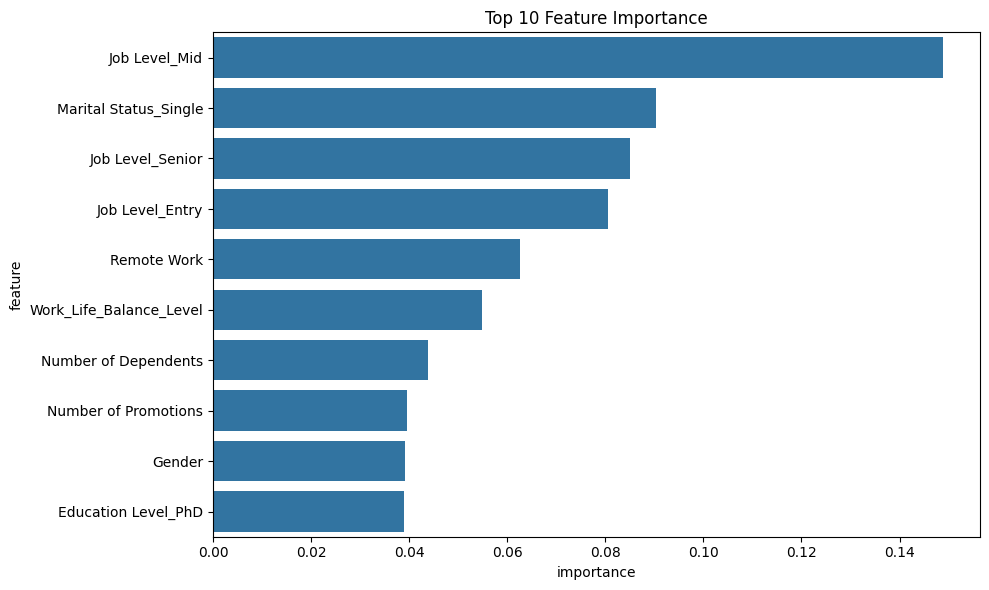


Fine-tuning model for senior segment

Fine-tuning model for senior
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:17:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:17:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:17:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:17:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/


Best parameters from random search:
{'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.15, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best cross-validation score: 0.4646
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:17:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:17:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:17:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:17:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/


Best parameters from grid search:
{'learning_rate': 0.12, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 200}
Best cross-validation score: 0.4576

Validation Set Performance:
accuracy: 0.8721
precision: 0.8026
recall: 0.5169
f1: 0.6289

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1780
           1       0.80      0.52      0.63       472

    accuracy                           0.87      2252
   macro avg       0.84      0.74      0.78      2252
weighted avg       0.87      0.87      0.86      2252



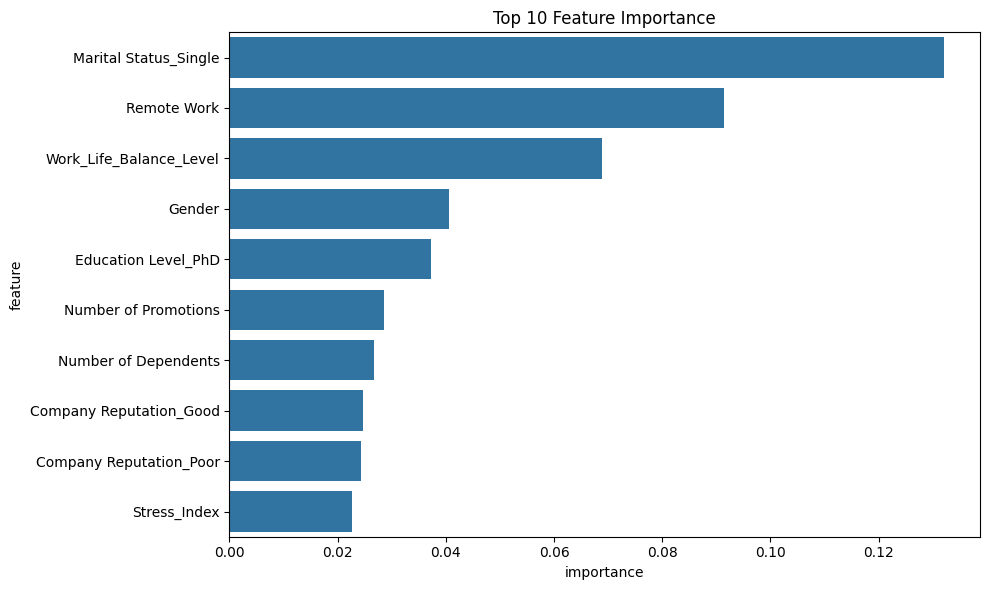


Fine-tuning model for entry segment

Fine-tuning model for entry
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:17:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:17:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:17:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:17:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/


Best parameters from random search:
{'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best cross-validation score: 0.8150
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:18:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:18:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:18:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:18:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/


Best parameters from grid search:
{'learning_rate': 0.012, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 100}
Best cross-validation score: 0.8135

Validation Set Performance:
accuracy: 0.7482
precision: 0.7366
recall: 0.9391
f1: 0.8256

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.42      0.55      1579
           1       0.74      0.94      0.83      2742

    accuracy                           0.75      4321
   macro avg       0.77      0.68      0.69      4321
weighted avg       0.76      0.75      0.72      4321



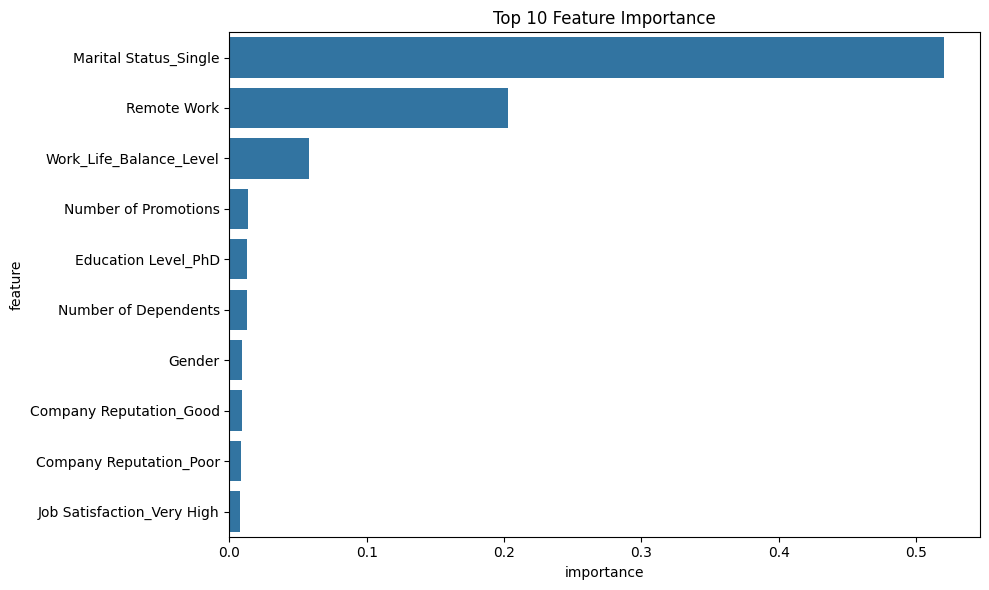


Fine-tuning model for mid segment

Fine-tuning model for mid
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:18:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:18:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:18:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:18:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/


Best parameters from random search:
{'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.7}
Best cross-validation score: 0.6993
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:18:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:18:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:18:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:18:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/qinyaomou/.local/lib/python3.10/site-packages/


Best parameters from grid search:
{'learning_rate': 0.12, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 250}
Best cross-validation score: 0.6999

Validation Set Performance:
accuracy: 0.7465
precision: 0.7332
recall: 0.7058
f1: 0.7192

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      2322
           1       0.73      0.71      0.72      1978

    accuracy                           0.75      4300
   macro avg       0.75      0.74      0.74      4300
weighted avg       0.75      0.75      0.75      4300



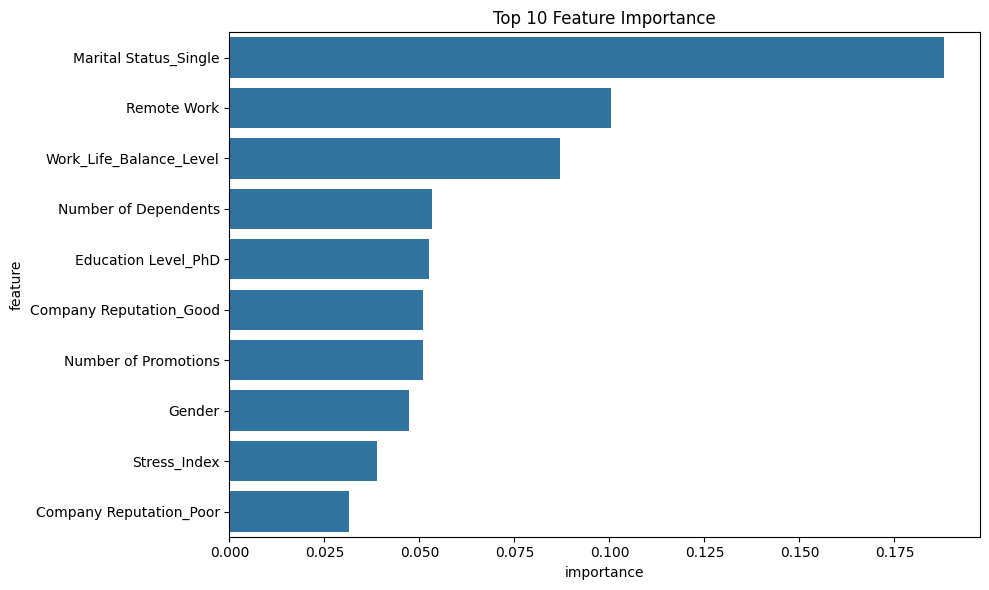


Model Performance Comparison:

Single Model:
{'accuracy': 0.7658419939299181, 'precision': 0.7552083333333334, 'recall': 0.7540446841294299, 'f1': 0.7546260601387818}

Segmented Models:

senior:
{'accuracy': 0.872113676731794, 'precision': 0.8026315789473685, 'recall': 0.5169491525423728, 'f1': 0.6288659793814433}

entry:
{'accuracy': 0.7482064336959037, 'precision': 0.7365560640732265, 'recall': 0.9390955506929248, 'f1': 0.8255851234369991}

mid:
{'accuracy': 0.7465116279069768, 'precision': 0.7331932773109243, 'recall': 0.7057633973710818, 'f1': 0.7192168985059247}


In [ ]:
def fine_tune_model(X_train, y_train, X_val, y_val, segment_name=None):
    """
    Fine-tune XGBoost model using GridSearchCV
    Returns best parameters and model performance
    """
    print(f"\nFine-tuning model for {segment_name if segment_name else 'all data'}")
    
    # First phase: Broad search with RandomizedSearchCV
    param_dist = {
        'max_depth': [3, 4, 5, 6, 7],
        'min_child_weight': [1, 3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.15],
        'n_estimators': [100, 200, 300],
        'subsample': [0.6, 0.7, 0.8, 0.9],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
        'gamma': [0, 0.1, 0.2]
    }
    
    # Initialize model
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        use_label_encoder=False
    )
    
    # Random Search
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=20,  # number of parameter settings sampled
        scoring='f1',
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit Random Search
    random_search.fit(X_train, y_train)
    
    print("\nBest parameters from random search:")
    print(random_search.best_params_)
    print(f"Best cross-validation score: {random_search.best_score_:.4f}")
    
    # Second phase: Fine-grained search around best parameters
    best_params = random_search.best_params_
    fine_param_grid = {
        'max_depth': [best_params['max_depth'] - 1, 
                     best_params['max_depth'], 
                     best_params['max_depth'] + 1],
        'min_child_weight': [best_params['min_child_weight'] - 1,
                           best_params['min_child_weight'],
                           best_params['min_child_weight'] + 1],
        'learning_rate': [best_params['learning_rate'] * 0.8,
                         best_params['learning_rate'],
                         best_params['learning_rate'] * 1.2],
        'n_estimators': [best_params['n_estimators'] - 50,
                        best_params['n_estimators'],
                        best_params['n_estimators'] + 50]
    }
    
    # Grid Search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=fine_param_grid,
        scoring='f1',
        cv=5,
        verbose=1,
        n_jobs=-1
    )
    
    # Fit Grid Search
    grid_search.fit(X_train, y_train)
    
    print("\nBest parameters from grid search:")
    print(grid_search.best_params_)
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Validate best model on validation set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    
    # Calculate validation metrics
    val_metrics = {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred)
    }
    
    print("\nValidation Set Performance:")
    for metric, value in val_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    
    # Visualize feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title('Top 10 Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return {
        'best_params': grid_search.best_params_,
        'best_model': best_model,
        'validation_metrics': val_metrics,
        'feature_importance': feature_importance
    }

# For single model
print("Fine-tuning single model...")
single_model_results = fine_tune_model(X_train, y_train, X_val, y_val)

# For segmented models
segments = {
    'senior': (X_train['Job Level_Senior'] == 1, X_val['Job Level_Senior'] == 1),
    'entry': (X_train['Job Level_Entry'] == 1, X_val['Job Level_Entry'] == 1),
    'mid': (X_train['Job Level_Mid'] == 1, X_val['Job Level_Mid'] == 1)
}

segmented_results = {}
for segment_name, (train_mask, val_mask) in segments.items():
    print(f"\nFine-tuning model for {segment_name} segment")
    
    # Get segment data
    X_train_segment = X_train[train_mask]
    y_train_segment = y_train[train_mask]
    X_val_segment = X_val[val_mask]
    y_val_segment = y_val[val_mask]
    
    # Fine-tune model for this segment
    segment_results = fine_tune_model(
        X_train_segment, 
        y_train_segment,
        X_val_segment,
        y_val_segment,
        segment_name
    )
    
    segmented_results[segment_name] = segment_results

# Compare performances
print("\nModel Performance Comparison:")
print("\nSingle Model:")
print(single_model_results['validation_metrics'])

print("\nSegmented Models:")
for segment, results in segmented_results.items():
    print(f"\n{segment}:")
    print(results['validation_metrics'])

In [ ]:
# Your senior segment showed best performance (0.84 accuracy)
print("Recommended Model Structure:")
print("Use segmented models with the following configurations:")

segment_recommendations = {
    'senior': {
        'why': "Best performing segment (0.84 accuracy)",
        'focus': "Retention prediction",
        'key_features': [
            'Marital Status_Single',
            'Remote Work',
            'Work-Life Balance'
        ],
        'recommended_params': {
            'max_depth': 4,  # Keep shallow to prevent overfitting
            'learning_rate': 0.05,  # Lower learning rate for stability
            'n_estimators': 200
        }
    },
    'entry': {
        'why': "Different pattern from senior (better at predicting leavers)",
        'focus': "Attrition prediction",
        'key_features': [
            'Marital Status_Single',
            'Remote Work',
            'Work-Life Balance_Fair'
        ],
        'recommended_params': {
            'max_depth': 5,
            'learning_rate': 0.1,
            'n_estimators': 200
        }
    },
    'mid': {
        'why': "Most balanced predictions",
        'focus': "General prediction",
        'key_features': [
            'Marital Status_Single',
            'Remote Work',
            'Work-Life Balance'
        ],
        'recommended_params': {
            'max_depth': 4,
            'learning_rate': 0.1,
            'n_estimators': 200
        }
    }
}

# Print recommendations
for segment, info in segment_recommendations.items():
    print(f"\n{segment.upper()} SEGMENT:")
    print(f"Reason: {info['why']}")
    print(f"Focus: {info['focus']}")
    print("Key Features:", ', '.join(info['key_features']))
    print("Recommended Parameters:", info['recommended_params'])

    

Recommended Model Structure:
Use segmented models with the following configurations:

SENIOR SEGMENT:
Reason: Best performing segment (0.84 accuracy)
Focus: Retention prediction
Key Features: Marital Status_Single, Remote Work, Work-Life Balance
Recommended Parameters: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 200}

ENTRY SEGMENT:
Reason: Different pattern from senior (better at predicting leavers)
Focus: Attrition prediction
Key Features: Marital Status_Single, Remote Work, Work-Life Balance_Fair
Recommended Parameters: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 200}

MID SEGMENT:
Reason: Most balanced predictions
Focus: General prediction
Key Features: Marital Status_Single, Remote Work, Work-Life Balance
Recommended Parameters: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 200}


=== Implementing Final Segmented Models ===

Processing senior segment:
Combined training data size: 13192
Best parameters: {'learning_rate': 0.12, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 200}

Segment Performance:
accuracy: 0.8261
precision: 0.6101
recall: 0.4199
f1: 0.4974
roc_auc: 0.8444

Top 5 Important Features:
                    feature  importance
47    Marital Status_Single    0.135828
8               Remote Work    0.103346
21  Work_Life_Balance_Level    0.057022
44      Education Level_PhD    0.035528
1                    Gender    0.033771

Processing entry segment:
Combined training data size: 26137
Best parameters: {'learning_rate': 0.012, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 100}

Segment Performance:
accuracy: 0.7227
precision: 0.7237
recall: 0.9168
f1: 0.8089
roc_auc: 0.8024

Top 5 Important Features:
                    feature  importance
47    Marital Status_Single    0.499962
8               Remote Work    0.202463
21  Work_Life_Ba

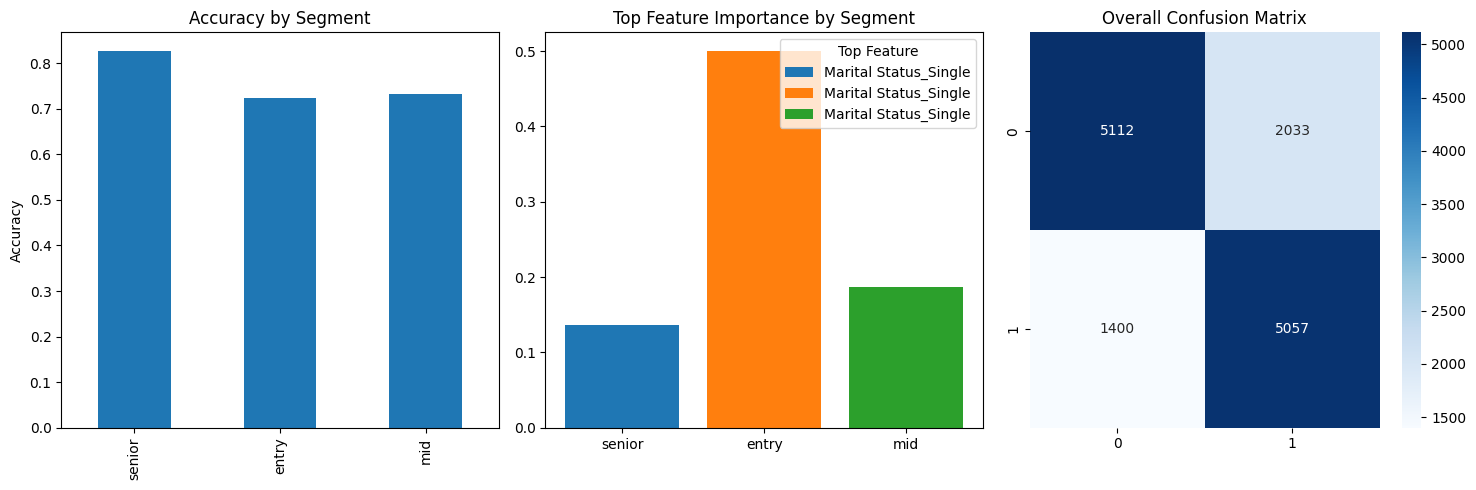


=== Overall Model Performance ===
accuracy: 0.7476
precision: 0.7133
recall: 0.7832
f1: 0.7466


In [ ]:
test_df = pd.read_csv("data/processed/test_engineered.csv")
X_test, y_test, = test_df.drop(columns=["Attrition"]), test_df["Attrition"]
        
def implement_final_segmented_models(X_train, y_train, X_val, y_val, X_test, y_test, tuned_results):
    """
    Implement final segmented models using best parameters from tuning
    
    Parameters:
    - X_train, y_train: Training data
    - X_val, y_val: Validation data
    - X_test, y_test: Test data (for final assessment only)
    - tuned_results: Results from fine-tuning containing best parameters for each segment
    """
    # Define segments
    segments = {
        'senior': (X_train['Job Level_Senior'] == 1, 
                  X_val['Job Level_Senior'] == 1,
                  X_test['Job Level_Senior'] == 1),
        'entry': (X_train['Job Level_Entry'] == 1, 
                 X_val['Job Level_Entry'] == 1,
                 X_test['Job Level_Entry'] == 1),
        'mid': (X_train['Job Level_Mid'] == 1, 
                X_val['Job Level_Mid'] == 1,
                X_test['Job Level_Mid'] == 1)
    }
    
    final_models = {}
    final_predictions = np.zeros_like(y_test)
    
    print("=== Implementing Final Segmented Models ===")
    
    for segment_name, (train_mask, val_mask, test_mask) in segments.items():
        print(f"\nProcessing {segment_name} segment:")
        
        # Combine train and validation data for this segment
        X_train_segment = X_train[train_mask]
        y_train_segment = y_train[train_mask]
        X_val_segment = X_val[val_mask]
        y_val_segment = y_val[val_mask]
        
        X_combined = pd.concat([X_train_segment, X_val_segment])
        y_combined = pd.concat([y_train_segment, y_val_segment])
        
        print(f"Combined training data size: {len(X_combined)}")
        
        # Get best parameters for this segment
        best_params = tuned_results[segment_name]['best_params']
        print("Best parameters:", best_params)
        
        # Create and train final model for this segment
        final_model = xgb.XGBClassifier(
            **best_params,
            objective='binary:logistic',
            random_state=42
        )
        
        # Train on combined data
        final_model.fit(X_combined, y_combined)
        
        # Get test data for this segment
        X_test_segment = X_test[test_mask]
        y_test_segment = y_test[test_mask]
        
        # Make predictions
        y_pred_segment = final_model.predict(X_test_segment)
        y_pred_proba_segment = final_model.predict_proba(X_test_segment)[:, 1]
        
        # Store predictions in combined array
        final_predictions[test_mask] = y_pred_segment
        
        # Calculate segment metrics
        segment_metrics = {
            'accuracy': accuracy_score(y_test_segment, y_pred_segment),
            'precision': precision_score(y_test_segment, y_pred_segment),
            'recall': recall_score(y_test_segment, y_pred_segment),
            'f1': f1_score(y_test_segment, y_pred_segment),
            'roc_auc': roc_auc_score(y_test_segment, y_pred_proba_segment)
        }
        
        # Get feature importance
        feature_imp = pd.DataFrame({
            'feature': X_combined.columns,
            'importance': final_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Store results
        final_models[segment_name] = {
            'model': final_model,
            'metrics': segment_metrics,
            'feature_importance': feature_imp,
            'predictions': y_pred_segment,
            'probabilities': y_pred_proba_segment
        }
        
        # Print segment results
        print(f"\nSegment Performance:")
        for metric, value in segment_metrics.items():
            print(f"{metric}: {value:.4f}")
        
        print("\nTop 5 Important Features:")
        print(feature_imp.head())
    
    # Calculate overall metrics
    overall_metrics = {
        'accuracy': accuracy_score(y_test, final_predictions),
        'precision': precision_score(y_test, final_predictions),
        'recall': recall_score(y_test, final_predictions),
        'f1': f1_score(y_test, final_predictions)
    }
    
    # Visualize results
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Segment Performance Comparison
    plt.subplot(1, 3, 1)
    metrics_df = pd.DataFrame([model['metrics'] for model in final_models.values()],
                            index=final_models.keys())
    metrics_df['accuracy'].plot(kind='bar')
    plt.title('Accuracy by Segment')
    plt.ylabel('Accuracy')
    
    # Plot 2: Feature Importance Comparison
    plt.subplot(1, 3, 2)
    for segment_name, results in final_models.items():
        top_feature = results['feature_importance'].iloc[0]
        plt.bar(segment_name, top_feature['importance'], 
                label=top_feature['feature'])
    plt.title('Top Feature Importance by Segment')
    plt.legend(title='Top Feature')
    
    # Plot 3: Confusion Matrices
    plt.subplot(1, 3, 3)
    cm = confusion_matrix(y_test, final_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Overall Confusion Matrix')
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== Overall Model Performance ===")
    for metric, value in overall_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return {
        'models': final_models,
        'overall_metrics': overall_metrics,
        'final_predictions': final_predictions
    }

# Use the function
final_results = implement_final_segmented_models(
    X_train, y_train, 
    X_val, y_val, 
    X_test, y_test, 
    segmented_results
)

# Function to make predictions for new data
def predict_with_segmented_models(new_data, final_models):
    """
    Make predictions for new data using appropriate segment models
    """
    predictions = np.zeros(len(new_data))
    probabilities = np.zeros(len(new_data))
    
    for idx, row in new_data.iterrows():
        # Determine segment
        if row['Job Level_Senior'] == 1:
            segment = 'senior'
        elif row['Job Level_Entry'] == 1:
            segment = 'entry'
        else:
            segment = 'mid'
        
        # Get prediction using appropriate model
        model = final_models[segment]['model']
        pred_proba = model.predict_proba(row.to_frame().T)[0]
        predictions[idx] = pred_proba.argmax()
        probabilities[idx] = pred_proba[1]
    
    return predictions, probabilities

In [ ]:
business_recommendations = {
    'senior_employees': [
        "Focus on work-life balance programs",
        "Maintain remote work options",
        "Consider marital status in retention strategies"
    ],
    'entry_level': [
        "Implement structured growth programs",
        "Enhance remote work opportunities",
        "Improve work-life balance initiatives"
    ],
    'mid_level': [
        "Balance work-life initiatives",
        "Provide clear career progression",
        "Flexible working arrangements"
    ]
}
print("\nBusiness Recommendations:")
for group, recs in business_recommendations.items():
    print(f"\n{group.replace('_', ' ').title()}:")
    for rec in recs:
        print(f"- {rec}")


Business Recommendations:

Senior Employees:
- Focus on work-life balance programs
- Maintain remote work options
- Consider marital status in retention strategies

Entry Level:
- Implement structured growth programs
- Enhance remote work opportunities
- Improve work-life balance initiatives

Mid Level:
- Balance work-life initiatives
- Provide clear career progression
- Flexible working arrangements


In [ ]:
next_steps = [
    "1. Implement segmented models with recommended parameters",
    "2. Validate on test set (only once after final implementation)",
    "3. Set up monitoring system for model performance",
    "4. Create separate intervention strategies for each segment",
    "5. Regular model retraining schedule (e.g., quarterly)"
]

print("\nRecommended Next Steps:")
for step in next_steps:
    print(step)


Recommended Next Steps:
1. Implement segmented models with recommended parameters
2. Validate on test set (only once after final implementation)
3. Set up monitoring system for model performance
4. Create separate intervention strategies for each segment
5. Regular model retraining schedule (e.g., quarterly)
